### Comparing kernel matrices with different approaches

In [71]:
using Flux,LinearAlgebra,CairoMakie,Random,ProgressMeter
Random.seed!(123)

TaskLocalRNG()

In [72]:
include("DenseNTK.jl")
include("normNTK.jl")

kernel (generic function with 2 methods)

We start by making a model using DenseNTK that works like Dense in Flux but is more general in a sense of calculating the kernel


In [73]:
Nh = 10_000
model = Chain(DenseNTK(1=>Nh,relu),DenseNTK(Nh=>1))
θ = Flux.params(model)
Nx = 40
xa = -1.0
xb = 1.0
xR = range(xa,stop=xb,length=Nx) 
x = hcat(xR...)


1×40 Matrix{Float64}:
 -1.0  -0.948718  -0.897436  -0.846154  …  0.846154  0.897436  0.948718  1.0

In [74]:

K_i = zeros(Float64,3*Nh+1,Nx)
for i = 1:Nx
    ∇_SIE = Flux.gradient(()-> model([x[i]])[1],θ)
    K_i[1:Nh,i] = ∇_SIE[θ[1]][:]
    K_i[Nh+1:2*Nh,i] = ∇_SIE[θ[2]][:]
    K_i[2*Nh+1:3*Nh,i] = ∇_SIE[θ[3]][:]
    K_i[3*Nh+1:3*Nh+1,i] = ∇_SIE[θ[4]][:] 
end

Kernel_SIE = K_i[1:3*Nh,:]'*K_i[1:3*Nh,:]
# eigen(Kernel_SIE).values

40×40 Matrix{Float64}:
 1.97326   1.91437   1.8589    1.79938   …  0.356934  0.338696  0.321581
 1.91437   1.87549   1.82249   1.76552      0.37319   0.355323  0.338625
 1.8589    1.82249   1.78597   1.73157      0.390424  0.372961  0.356711
 1.79938   1.76552   1.73157   1.69785      0.408665  0.391628  0.375849
 1.74094   1.70956   1.67814   1.64696      0.427379  0.410861  0.395646
 1.68125   1.65237   1.62347   1.59483   …  0.447114  0.431126  0.416486
 1.62391   1.59743   1.57096   1.54478      0.468674  0.453184  0.439086
 1.56411   1.54004   1.51602   1.49231      0.491187  0.476278  0.462808
 1.50728   1.48553   1.46385   1.4425       0.515871  0.501558  0.488727
 1.45113   1.43164   1.41225   1.39322      0.541276  0.527658  0.515568
 ⋮                                       ⋱                      
 0.489424  0.502213  0.515794  0.530243     1.46719   1.48689   1.50911
 0.464041  0.477494  0.491769  0.506936     1.51889   1.54088   1.56543
 0.439741  0.453768  0.46865   0.48444

In [75]:
K = kernel(model,x,true)


40×40 Matrix{Float64}:
 1.97326   1.91437   1.8589    1.79938   …  0.356934  0.338696  0.321581
 1.91437   1.87549   1.82249   1.76552      0.37319   0.355323  0.338625
 1.8589    1.82249   1.78597   1.73157      0.390424  0.372961  0.356711
 1.79938   1.76552   1.73157   1.69785      0.408665  0.391628  0.375849
 1.74094   1.70956   1.67814   1.64696      0.427379  0.410861  0.395646
 1.68125   1.65237   1.62347   1.59483   …  0.447114  0.431126  0.416486
 1.62391   1.59743   1.57096   1.54478      0.468674  0.453184  0.439086
 1.56411   1.54004   1.51602   1.49231      0.491187  0.476278  0.462808
 1.50728   1.48553   1.46385   1.4425       0.515871  0.501558  0.488727
 1.45113   1.43164   1.41225   1.39322      0.541276  0.527658  0.515568
 ⋮                                       ⋱                      
 0.489424  0.502213  0.515794  0.530243     1.46719   1.48689   1.50911
 0.464041  0.477494  0.491769  0.506936     1.51889   1.54088   1.56543
 0.439741  0.453768  0.46865   0.48444

In [76]:
round.(K[:,:],digits=13)==round.(Kernel_SIE[:,:],digits=13)

true

In [77]:
eigen(Kernel_SIE).values
λ = eigen(K).values
λ = abs.(λ)
λ = sort!(λ)



for i = 1:Nx
    if λ[i] == 0
        λ[i] = 10^(-19)
    end
end

λ

40-element Vector{Float64}:
  0.0034371862513283766
  0.0038815767870782987
  0.003975942442879214
  0.004130162617256351
  0.004235480717315266
  0.004331855981372241
  0.004404162394947068
  0.004503495674454009
  0.00462162143112666
  0.0048079900378979554
  ⋮
  0.04487754481810287
  0.056768348597830906
  0.07925381575739175
  0.11311851116044397
  0.19334953243171413
  0.3789791985505866
  1.3867519802078425
 12.69276324866799
 38.23382645100299

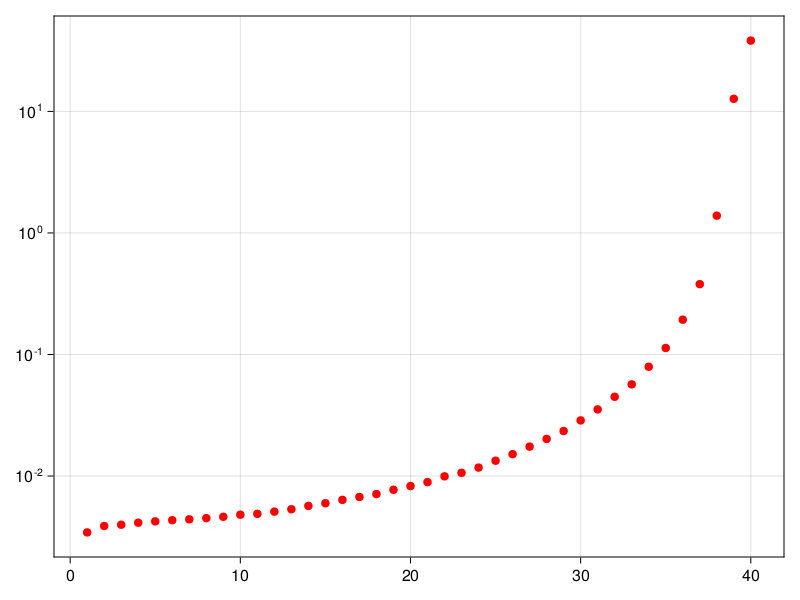

In [78]:
fig = Figure()
ax1 = Axis(fig[1,1],yscale=log10)
s1 = CairoMakie.scatter!(ax1,λ[:],color=:red)
fig


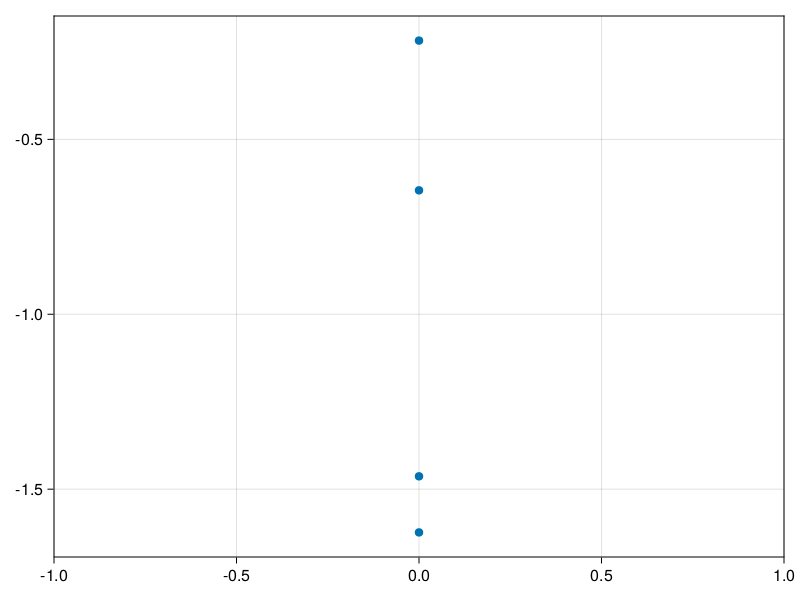

In [79]:
t = [0]
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,t,θ[1][1:4])
fig



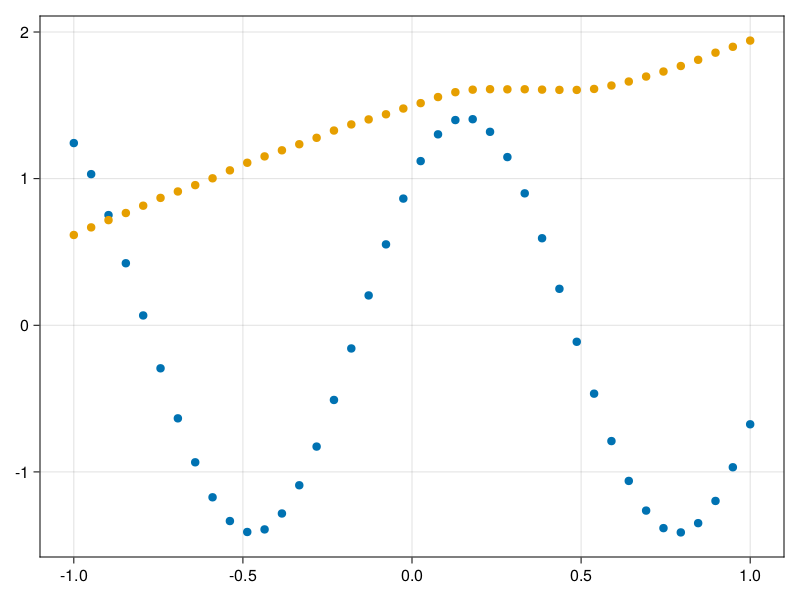

In [80]:
x_train = x
f = x->sin(5*x)+cos(5*x)
y_train = map(f,x_train)
y_hat = model(x_train)
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,x_train[:],y_train[:])
CairoMakie.scatter!(ax1,x_train[:],y_hat[:])
fig


In [81]:
y_train_hat = model(x_train)
Loss(model,x,y) = Flux.mse(y,model(x))
loss = Loss(model,x_train,y_train)
train_data = [(x_train,y_train)]



1-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([-1.0 -0.9487179487179487 … 0.9487179487179487 1.0], [1.2425864601263648 1.0307089968649938 … -0.9683175944810455 -0.6752620891999122])

In [82]:

train_data = [(x_train,y_train)]
η = 1/λ[end]
Nepoch = 50_000
L = []


layer = 1
θ_stop = 6
θ_s = zeros(Nepoch,θ_stop)
@showprogress for epoch = 1:Nepoch
    Flux.train!(Loss,model,train_data,Descent(η))
    for i = 1:θ_stop
        θ_s[epoch,i] = Flux.params(model)[layer][i]
    end
        
    push!(L,Loss(model,x_train,y_train))
end



In [ ]:
L = hcat(L...)

In [ ]:
t = 1:Nepoch
dt = hcat(t...)

In [ ]:
fig = Figure(resolution=(1000, 600))

# Creating a grid layout for the figure: 1 row, 2 columns
# The first column for the plot, the second for the legend
grid = fig[1, 1] = GridLayout()
ax1 = Axis(grid[1, 1], title=L"Epochs = %$Nepoch, Nh = %$Nh", xlabel=L"t", ylabel=L"θ_i(t)")

# Plotting data
for i = 1:θ_stop
    lines!(ax1, dt[:], θ_s[:,i], label=L"θ_{%$i}(t)")
end

# Adjusting the layout to leave space for the legend outside the plot
grid[1, 2] = Legend(fig, ax1, "Parameters", valign=:top, orientation=:vertical)


fig

In [ ]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Loss",xlabel="Epochs",ylabel="Loss")
CairoMakie.scatter!(ax1,dt[:],L[:])


fig


In [ ]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Data, sin(5x)+cos(5x)")
CairoMakie.scatter!(ax1,x_train[:],y_train[:],label="Data")
CairoMakie.scatter!(ax1,x_train[:],model(x_train)[:],color=:red,label="Fit")
axislegend(ax1,position=:rt)
fig


### Parameters 

#### Run1 500000 Epochs RELU
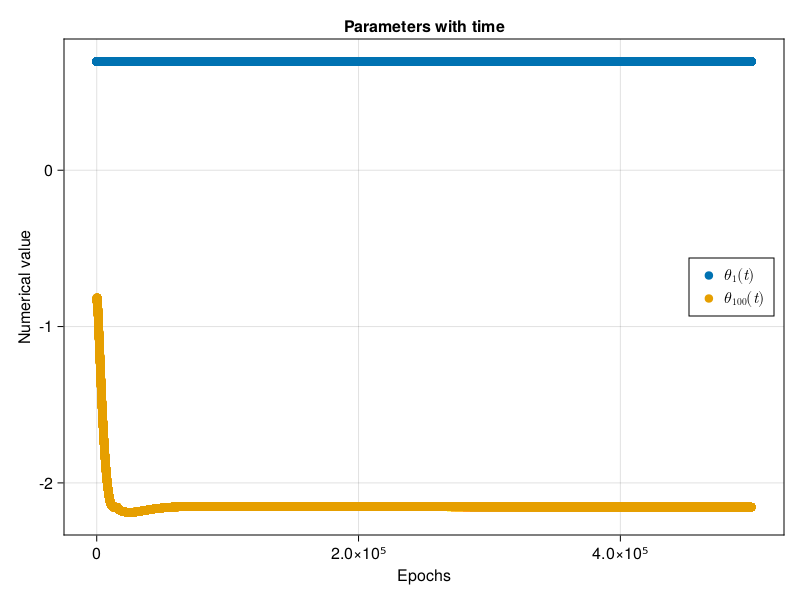

#### Run2 500000 Epochs RELU
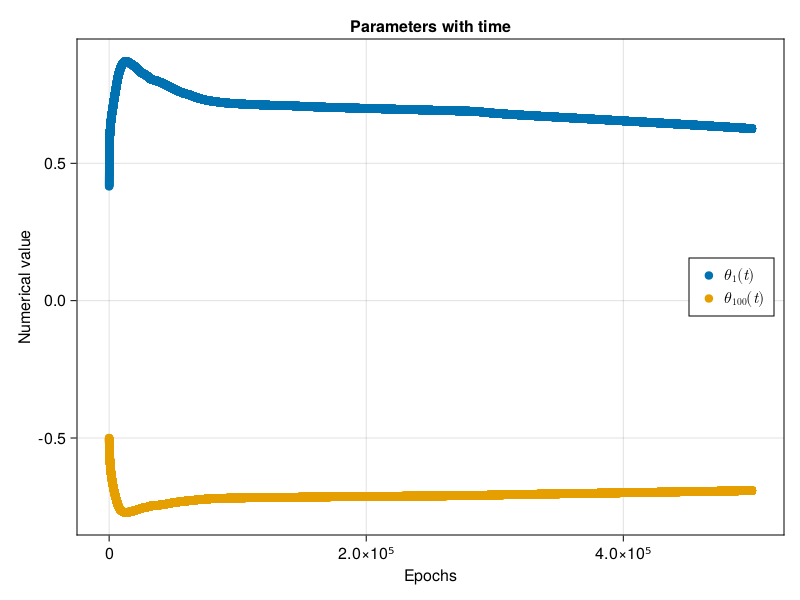

#### Run3 50000 Epochs RELU
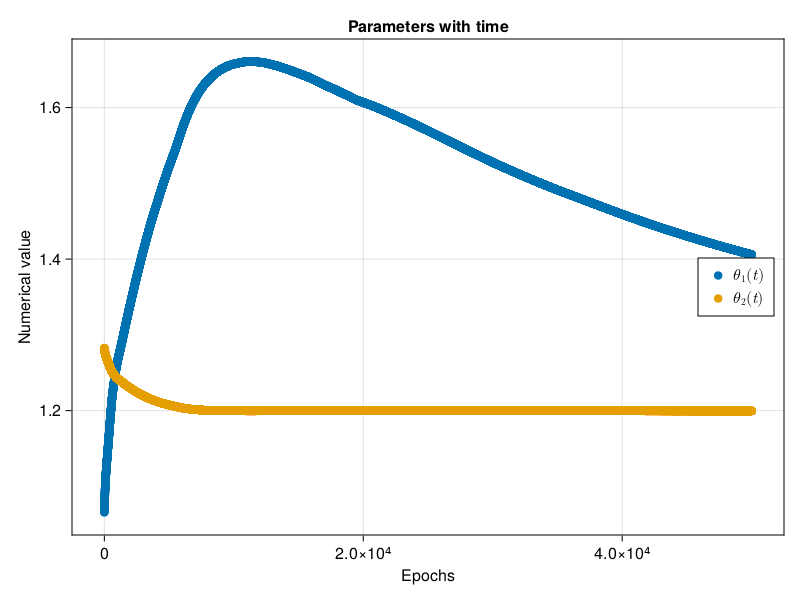

#### Run4 50000 Epochs RELU
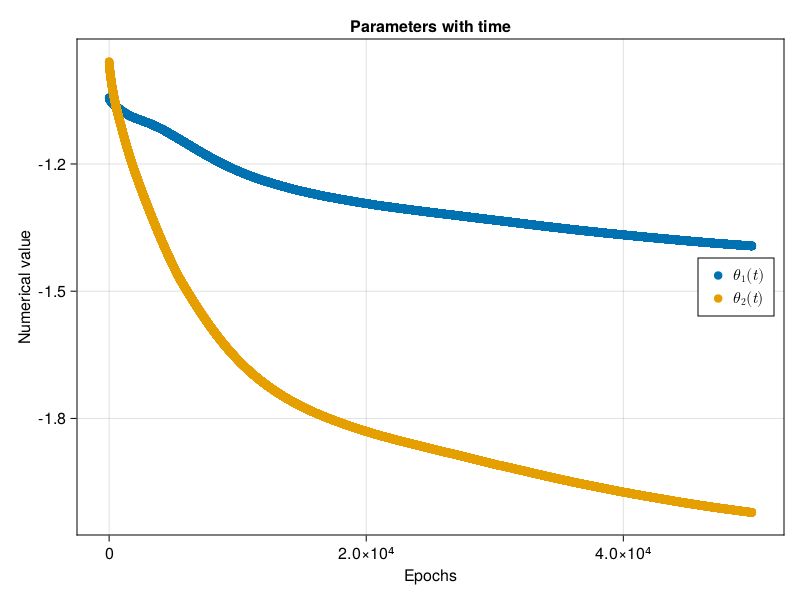


#### Run5 50000 Epochs tanh
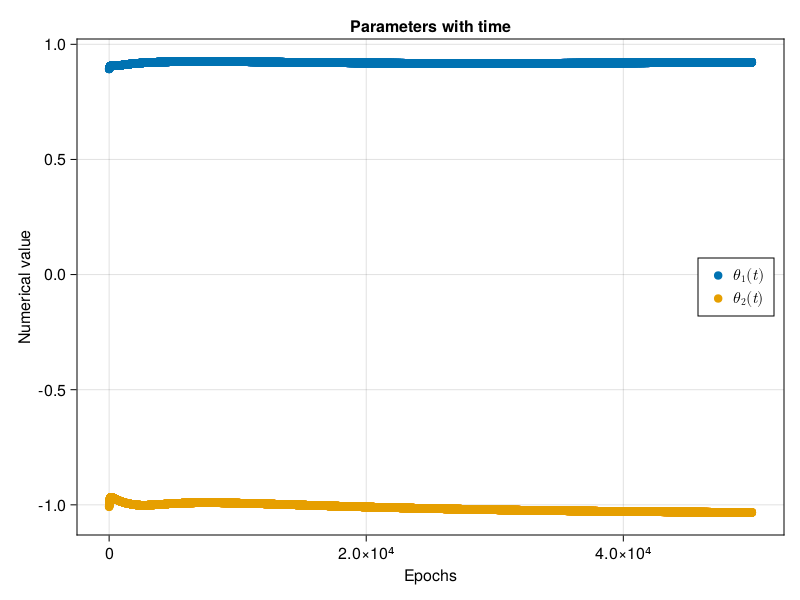

#### Run6 50000 Eochs tanh
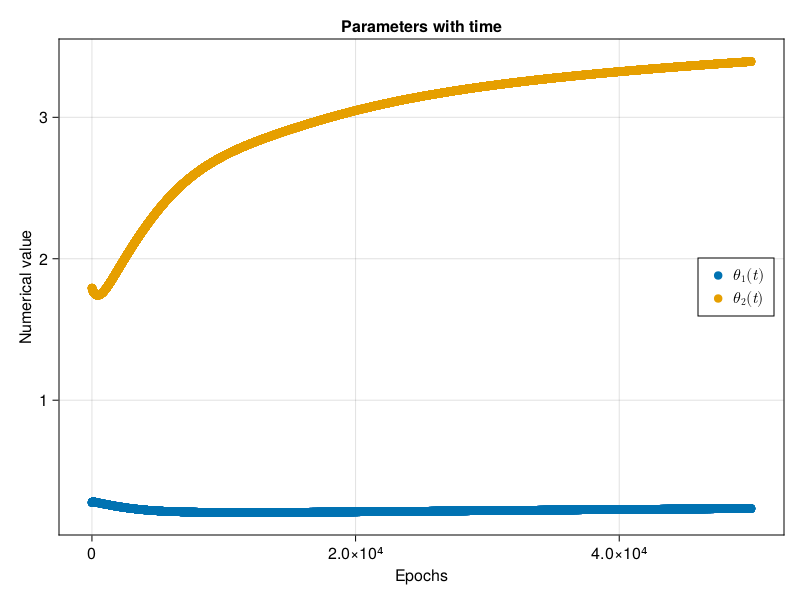